In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [2]:
import numpy as np

In [3]:
# Configure the device gpu is required for faster 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
IMG_SIZE = 512
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3

In [5]:
def load_img(path):
    img = cv2.imread(path)
    return img

def imshow(img, title_img = None):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.array(img / 255).clip(0,1)
    plt.figure(figsize = (10,10))
    plt.axis("off")
    if title_img is not None:
        plt.title(title_img)
    plt.imshow(img)
    plt.show()

def preprocess_image(img):
    h, w, c = img.shape
    img_size = tuple([int(float(IMG_SIZE) / max(h,w) * x) for x in [h,w]])
    loader = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize(img_size), 
                                transforms.ToTensor()])
    normalize = transforms.Normalize([103.939, 116.779, 123.68],[1,1,1])
    tensor = normalize(loader(img) * 255)
    tensor = tensor.unsqueeze(0)
    return tensor

def post_process_image(tensor):
    loader = transforms.Compose([transforms.Normalize([-103.939, -116.779, -123.68],[1,1,1])])
    tensor = tensor.squeeze()
    img = loader(tensor)
    img = img.cpu().numpy()
    img = img.transpose(1,2,0)
    return img

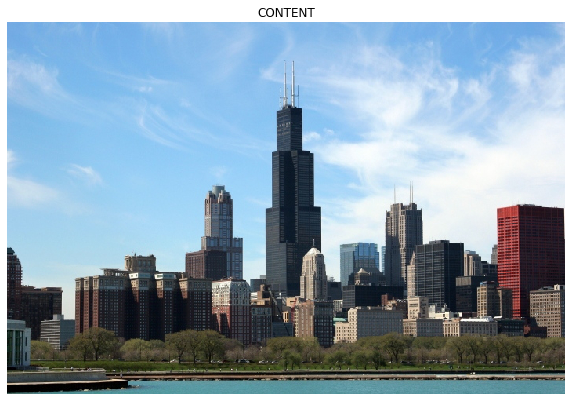

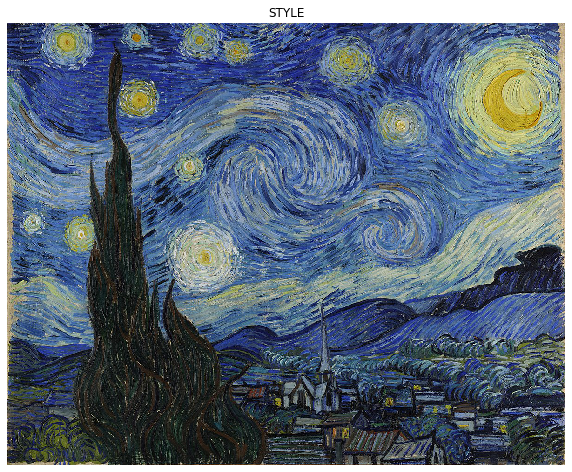

In [6]:
content_img = load_img("./data/images/chicago.jpg")
style_img = load_img("./data/images/style3.jpg")


imshow(content_img, title_img = "CONTENT")
imshow(style_img, title_img = "STYLE")

In [7]:
vgg19 = models.vgg19(pretrained=True)
model = copy.deepcopy(vgg19.features)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

In [8]:
def gram_matrix(tensor):
    # Example tenor size :  (1, 256, 56, 56)
    a, b, c, d = tensor.size()
    x = tensor.view(a * b, c * d)
    # shape : (256, 3136)
    G = torch.mm(x, x.t())
    return G.div(a * b * c * d)

mse_loss = torch.nn.MSELoss()
def ContentLoss(content, target):
    loss = mse_loss(content, target)
    return loss

def StyleLoss(style, target):
    loss = mse_loss(style, target)
    return loss

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [9]:
for name, layer in vgg19._modules.items():
    print(name)
    print(layer)

features
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18

In [10]:
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2' # Content layers
    }
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name == "22"):
                features[layers[name]] = x
            elif (name == "31"):
                features[layers[name]] = x
            else:
                a, b, c, d = x.size()
                features[layers[name]] = gram_matrix(x)
            if (name == "35"):
                break
    return features

In [11]:
def noise_image(content_img):
    b, c ,h, w = content_img.size()
    tensor = torch.randn((c, h, w)).mul(0.001).unsqueeze(0)
    return tensor

In [12]:
content_img = preprocess_image(content_img).to(device)
style_img = preprocess_image(style_img).to(device)
print(content_img.size())
print(style_img.size())

torch.Size([1, 3, 340, 512])
torch.Size([1, 3, 405, 512])


In [13]:
noise_input = noise_image(content_img)
noise_input = noise_input.to(device).requires_grad_()
print(noise_input.size())

torch.Size([1, 3, 340, 512])


In [14]:
optimizer = optim.Adam([noise_input], lr=10)

In [15]:
def run_style_transfer(EPOCHS):
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.1, 'relu2_2': 0.1, 'relu3_3': 0.3, 'relu4_3': 0.3, 'relu5_3': 0.2}
    c_feat = get_features(model, content_img)
    s_feat = get_features(model, style_img)
    i = [0]
    while i[0] < EPOCHS:
        def train_step():
            optimizer.zero_grad()
            g_feat = get_features(model, noise_input)
            c_loss = 0
            s_loss = 0
            for k in content_layers:
                c_loss += content_weights[k] * ContentLoss(g_feat[k], c_feat[k])
            for m in style_layers:
                s_loss += style_weights[m] * StyleLoss(g_feat[m], s_feat[m])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(noise_input.clone().detach())
            total_loss = c_loss + s_loss + t_loss
            
            total_loss.backward(retain_graph = True)
            i[0]+=1
            if (i[0] % 100 == 0):
                print("EPOCH %d" % (i[0]))
                print("StyleLoss: %.3f ContentLoss : %.3f TVLoss : %.3f" % (s_loss.item(), c_loss.item(), t_loss.item()))
                img = post_process_image(noise_input.clone().detach())
                imshow(img)
            return total_loss
        
        optimizer.step(train_step)
    return noise_input

EPOCH 100
StyleLoss: 2796.726 ContentLoss : 2766.704 TVLoss : 21899.850


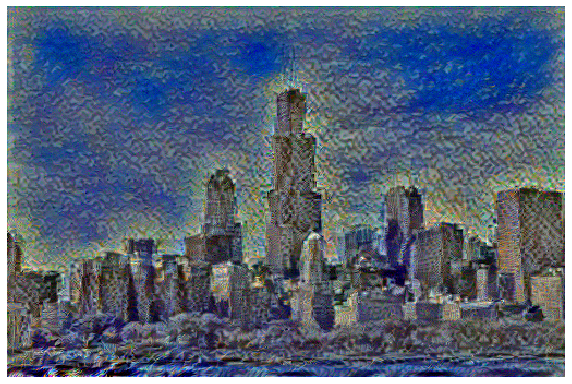

EPOCH 200
StyleLoss: 2050.483 ContentLoss : 2304.692 TVLoss : 22084.975


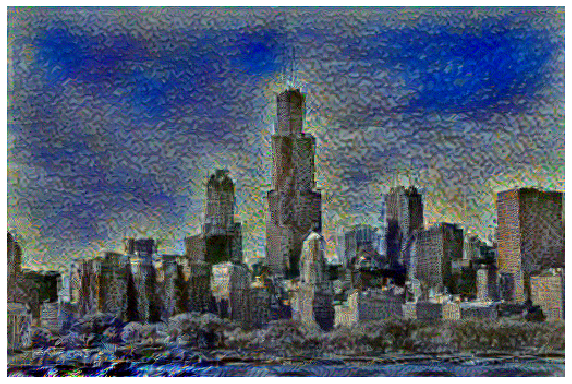

EPOCH 300
StyleLoss: 1810.489 ContentLoss : 2008.723 TVLoss : 22646.668


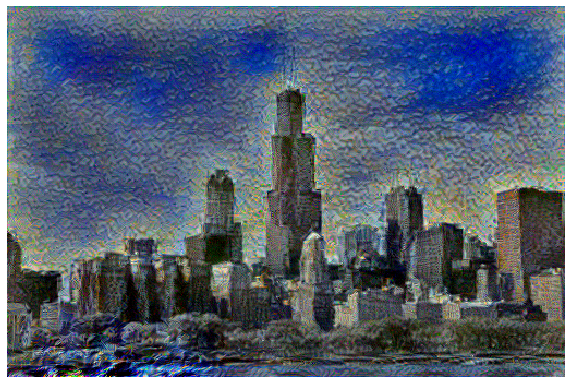

EPOCH 400
StyleLoss: 1673.472 ContentLoss : 1915.683 TVLoss : 23216.209


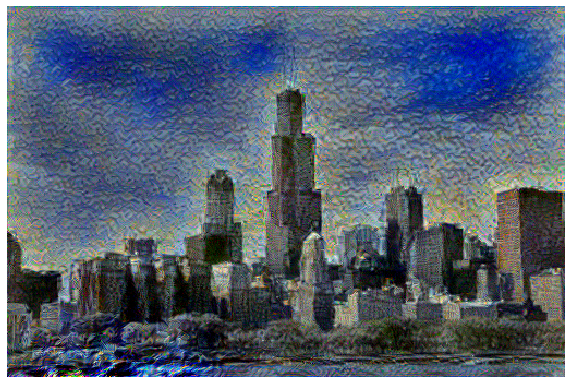

EPOCH 500
StyleLoss: 1631.282 ContentLoss : 1892.413 TVLoss : 23932.939


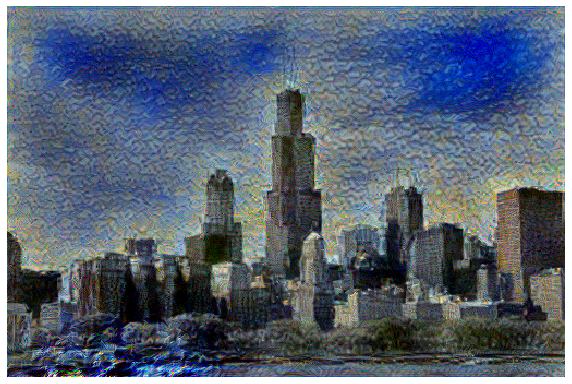

EPOCH 600
StyleLoss: 1598.974 ContentLoss : 1761.860 TVLoss : 24584.354


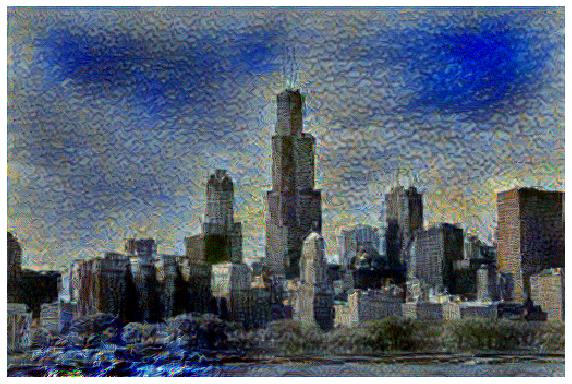

EPOCH 700
StyleLoss: 1537.689 ContentLoss : 1714.391 TVLoss : 25122.531


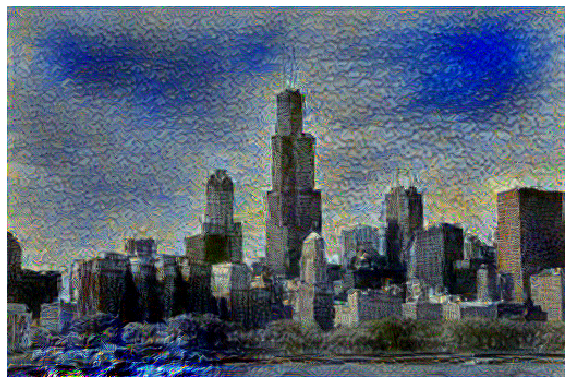

EPOCH 800
StyleLoss: 1576.954 ContentLoss : 1790.243 TVLoss : 25913.818


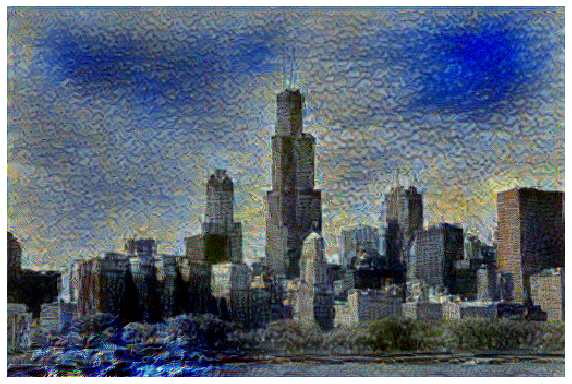

EPOCH 900
StyleLoss: 1574.829 ContentLoss : 1880.686 TVLoss : 26765.777


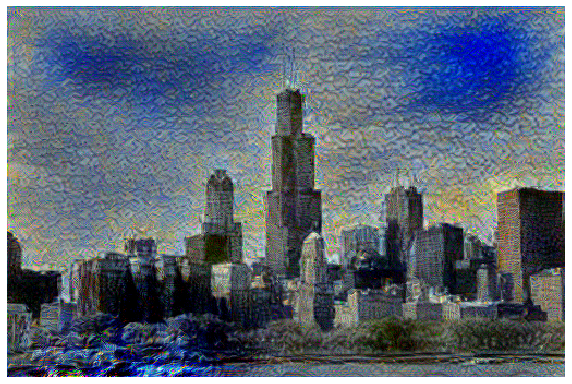

EPOCH 1000
StyleLoss: 1488.673 ContentLoss : 1644.938 TVLoss : 27118.854


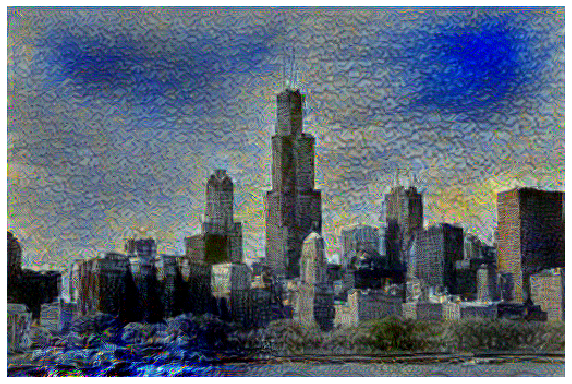

In [16]:
final = run_style_transfer(1000)